In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow_addons as tfa
from scipy import misc
import time

In [2]:
import tensorflow as tf

print(tf.__version__)
# importing the tensorflow package
tf.test.is_built_with_cuda()
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


2.3.1
Num GPUs: 0


In [3]:
import pathlib
#https://cdn-144.anonfiles.com/J8c8S3s0p4/935d48c2-1606216539/data.tar.gz
data = r"C:\Users\tobia\Samlet CNN\data"
data_dir = pathlib.Path(data)
type(data_dir)


pathlib.WindowsPath

In [4]:
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

35886


In [5]:
#Train
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Val
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'), shuffle=False)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


28709
3589


In [6]:
for f in train_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\22020.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\13824.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\23954.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\4\\9433.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\2\\579.png'


In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('train/*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1' '2' '3' '4' '5' '6']


In [8]:
batch_size = 32
img_height = 48
img_width = 48

In [9]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original,cmap='gray')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented,cmap='gray')

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (48, 48, 1)
Label:  6


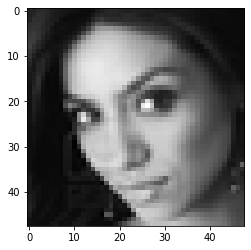

In [14]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"),cmap='gray')
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [15]:
def resize_and_rescale(image, label):
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image/ 255.0)
    #image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label


In [16]:
def augment(image,label):
    random_number = random.uniform(0.1,0.8)
    random_number_flip = random.uniform(0,2)
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 1])
    image = tf.image.adjust_brightness(image,0.6)
    
    #shear
    random_number_shear = random.uniform(-0.3,0.3)
    shear = random_number_shear
    shear_rotate = shear * -20
    image = tfa.image.transform(image, [1.0, shear, shear_rotate, 0.0, 1.0, 0.0, 0.0, 0.0])

    #distortion
    random_number_distortion = random.uniform(0,5)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=random_number_distortion, dtype=tf.float32)
    image = tf.add(image, noise)
    
    #random erase
    
        
    if random_number_flip > 1:
        image = tf.image.flip_left_right(image)
    #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    #image = tf.clip_by_value(image, 0, 1)
    return image, label

Image shape:  (48, 48, 1)
Label:  6
<ParallelMapDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>
virk!
<PrefetchDataset shapes: ((None, 48, 48, 1), (None,)), types: (tf.float32, tf.int64)>


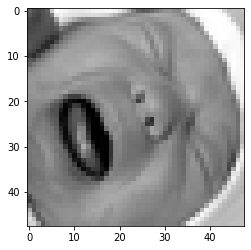

In [17]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"),cmap='gray')
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print(train_ds)
    
train_ds = (
    train_ds
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)    
orgDataset = train_ds

#.map(augment, num_parallel_calls=AUTOTUNE)
print("virk!")
print(train_ds)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

image_batch, label_batch = next(iter(train_ds))
plt.imshow(image_batch[1].numpy().astype("uint8"),cmap='gray')


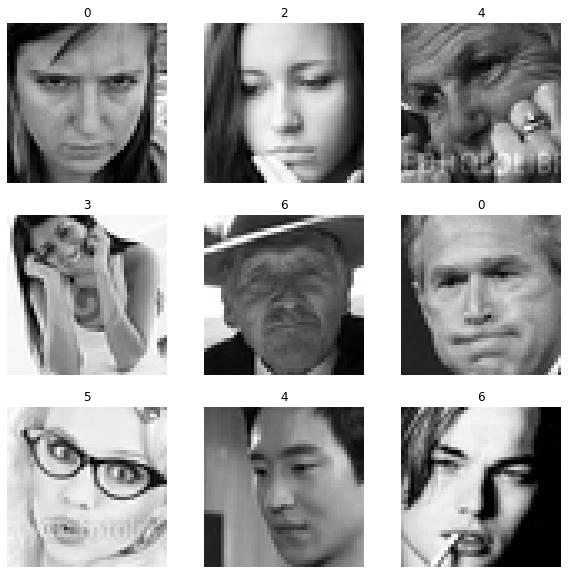

In [18]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")


numpy.ndarray

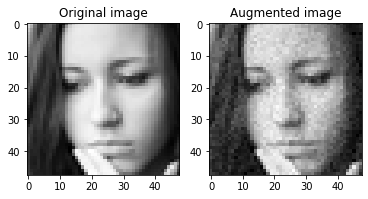

In [19]:
image = image_batch[1].numpy().astype("uint8")
noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=10, dtype=tf.float32)
flipped = tf.add(image, noise)
visualize(image, flipped)
type(image)

In [20]:
class CustomCallback(keras.callbacks.Callback):
   
    def on_epoch_end(self, epoch, logs=None):      
        image_batch, label_batch = next(iter(train_ds))
        plt.figure(figsize=(10, 10))
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
            label = label_batch[i]
            plt.title(class_names[label])
            plt.axis("off")

In [21]:
def visualize2(original):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    image = colorImage(original)
    plt.imshow(image)

In [22]:
def flipImage(image):
    flipped = tf.image.flip_left_right(image)
    
def colorImage(image):
    image = tf.image.adjust_brightness(image,0.5)
    return image

In [23]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 7
cnn = tf.keras.models.Sequential([
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Flatten(),
layers.Dense(units=128, activation='relu'),
layers.Dense(units=7,activation='softmax')
])

cnn.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])



In [ ]:
n_epoch = 50
accuracy = []
val_accuracy = []
loss_graph = []
loss_accuracy = []

start = time.time()
for i in range(n_epoch):
    try:
        print(f"{i+1}/{n_epoch}")
        history = cnn.fit(train_ds, validation_data = val_ds, epochs = 1, callbacks=[CustomCallback()]
)
        train_ds = (
            orgDataset
            .unbatch()
            .shuffle(1000)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
         )
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        loss_graph.append(history.history['loss'])
        loss_accuracy.append(history.history['val_loss'])
        
    except ValueError:
        print(train_ds)
end = time.time()
duration = end - start
print(f"It took {duration} seconds")


1/50
898/898 [==============================] - 34s 38ms/step - loss: 2.1226 - accuracy: 0.2866 - val_loss: 1.6603 - val_accuracy: 0.3469
2/50
898/898 [==============================] - 36s 40ms/step - loss: 1.7068 - accuracy: 0.3155 - val_loss: 1.6195 - val_accuracy: 0.3675
3/50
898/898 [==============================] - 36s 40ms/step - loss: 1.6650 - accuracy: 0.3403 - val_loss: 1.6215 - val_accuracy: 0.3539
4/50
898/898 [==============================] - 36s 40ms/step - loss: 1.6179 - accuracy: 0.3647 - val_loss: 1.6213 - val_accuracy: 0.3650
5/50
898/898 [==============================] - 35s 39ms/step - loss: 1.6285 - accuracy: 0.3549 - val_loss: 1.5658 - val_accuracy: 0.3879
6/50
898/898 [==============================] - 35s 39ms/step - loss: 1.5749 - accuracy: 0.3804 - val_loss: 1.5240 - val_accuracy: 0.4118
7/50
898/898 [==============================] - 36s 40ms/step - loss: 1.5402 - accuracy: 0.3976 - val_loss: 1.5207 - val_accuracy: 0.4149
8/50
898/898 [====================

<ipython-input-20-dab693d56437>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


22/50
898/898 [==============================] - 35s 39ms/step - loss: 1.3940 - accuracy: 0.4655 - val_loss: 1.3621 - val_accuracy: 0.4909
23/50
898/898 [==============================] - 35s 39ms/step - loss: 1.3454 - accuracy: 0.4858 - val_loss: 1.3480 - val_accuracy: 0.4815
24/50
898/898 [==============================] - 35s 39ms/step - loss: 1.3279 - accuracy: 0.4906 - val_loss: 1.3326 - val_accuracy: 0.4890
25/50
898/898 [==============================] - 34s 38ms/step - loss: 1.3830 - accuracy: 0.4720 - val_loss: 1.3356 - val_accuracy: 0.4901
26/50
898/898 [==============================] - 36s 40ms/step - loss: 1.3805 - accuracy: 0.4695 - val_loss: 1.3597 - val_accuracy: 0.4929
27/50
898/898 [==============================] - 37s 41ms/step - loss: 1.3414 - accuracy: 0.4841 - val_loss: 1.3360 - val_accuracy: 0.4968
28/50
898/898 [==============================] - 35s 39ms/step - loss: 1.3508 - accuracy: 0.4841 - val_loss: 1.3418 - val_accuracy: 0.4951
29/50
898/898 [============

In [ ]:
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(loss_graph)
plt.plot(loss_accuracy)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image
from PIL import Image, ImageOps 
test_image = image.load_img(r'C:\Users\tobia\Samlet CNN\data\test\4\33606.png', target_size = (48, 48))
test_image = ImageOps.grayscale(test_image) 
plt.imshow(test_image,cmap='gray')



In [ ]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
result = result.tolist()
result = result[0]

tal = [1,2,3,4,5,7,6]
mood = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
plt.title('Mood')
plt.ylabel('accuracy')
plt.bar(mood, result)
plt.show()


In [ ]:
image_batch, label_batch = next(iter(train_ds))